# HyperparameterTesting

Choosing the right LR for each model by running it on all tasks.

In [1]:
import DataLoader, Training, os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
data_path = "F:/Masterthesis/Data/"

### EEGNet

In [63]:
## EEGNet LR testing
preprocessing = "medium"
model_name = "eegnet"
model_folder = "HyperparameterTesting"
n_epochs = 25
n_splits = 1

# run all tasks for different learning rates
results = []
for task in ["N170", "N400", "P3"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.05, 0.01, 0.005]:
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64, additional_save_param="_"+str(lr))
        accuracy = Training.load_exp(model_folder, model_name, task, 
                                     preprocessing, n_splits, 
                                     additional_save_param="_"+str(lr))["valid_balanced_accuracy"][n_epochs-1]
        results.append((task, lr, accuracy))

# save results        
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
df_path = os.getcwd()+"\\HyperparameterTesting\\"
df.to_csv(df_path+"eegnet_lr.csv",index=False)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5124        0.7555                     0.5429        0.7309  0.0500  1.4300
      2                     0.5716        0.6789                     0.5517        0.6874  0.0498  1.3734
      3                     0.6292        0.6471                     0.6605        0.6375  0.0491  1.3725
      4                     0.6485        0.6264                     0.6765        0.6312  0.0481  1.3727
      5                     0.6704        0.6142                     0.6003        0.6550  0.0467  1.3773
      6                     0.6703        0.6118                     0.5786        0.6671  0.0448  1.3743
      7                     0.6806        0.6037              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5823        0.6966                     0.6645        0.6375  0.0100  1.3783
      2                     0.6577        0.6293                     0.6737        0.6155  0.0100  1.3783
      3                     0.6853        0.5942                     0.7055        0.5758  0.0098  1.3788
      4                     0.7017        0.5796                     0.7164        0.5619  0.0096  1.3784
      5                     0.7078        0.5701                     0.6998        0.5795  0.0093  1.3777
      6                     0.7246        0.5542                     0.7347        0.5549  0.0090  1.3787
      7                     0.7383        0.5357                     0.7372        0.5394  0.0085  1.3775
      8                     0.7399        0.52

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5970        0.6830                     0.6500        0.6387  0.0050  1.3813
      2                     0.6614        0.6228                     0.6761        0.6072  0.0050  1.3793
      3                     0.6893        0.5904                     0.6872        0.5771  0.0049  1.3789
      4                     0.7099        0.5734                     0.7171        0.5523  0.0048  1.3784
      5                     0.7327        0.5541                     0.7157        0.5594  0.0047  1.3778
      6                     0.7296        0.5439                     0.7355        0.5138  0.0045  1.3789
      7                     0.7476        0.5234                     0.7366        0.5220  0.0043  1.3773
      8                     0.7530        0.51

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6436        0.7069                     0.6981        0.8881  0.0500  0.8856
      2                     0.6892        0.5798                     0.6974        0.7338  0.0498  0.8944
      3                     0.7062        0.5698                     0.6812        0.5997  0.0491  0.9324
      4                     0.6626        0.6234                     0.6873        0.7648  0.0481  0.8652
      5                     0.7183        0.5707                     0.5598        0.8832  0.0467  0.8562
      6                     0.7122        0.5694                     0.7162        0.5638  0.0448  0.8269
      7                     0.6852        0.5881              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6414        0.6521                     0.7066        0.5854  0.0100  0.8283
      2                     0.7123        0.5697                     0.7235        0.5452  0.0100  0.8262
      3                     0.7281        0.5399                     0.7201        0.5577  0.0098  0.8249
      4                     0.7316        0.5506                     0.7123        0.5845  0.0096  0.8255
      5                     0.7436        0.5172                     0.7342        0.5299  0.0093  0.8258
      6                     0.7500        0.5125                     0.6913        0.6463  0.0090  0.8258
      7                     0.7514        0.5026                     0.7433        0.5327  0.0085  0.8255
      8                     0.7563        0.50

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6237        0.6733                     0.6792        0.5929  0.0050  0.8258
      2                     0.7055        0.5688                     0.7288        0.5591  0.0050  0.8259
      3                     0.7232        0.5463                     0.7342        0.5504  0.0049  0.8258
      4                     0.7190        0.5477                     0.7355        0.5411  0.0048  0.8263
      5                     0.7444        0.5244                     0.7288        0.5319  0.0047  0.8258
      6                     0.7497        0.5191                     0.7464        0.5084  0.0045  0.8263
      7                     0.7373        0.5161                     0.7495        0.5159  0.0043  0.8266
      8                     0.7605        0.50

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6257        0.6955                     0.5737        0.8838  0.0500  1.8007
      2                     0.6768        0.6135                     0.6807        0.6042  0.0498  1.7994
      3                     0.6617        0.6294                     0.6937        0.6019  0.0491  1.8004
      4                     0.6637        0.6118                     0.5429        0.6967  0.0481  1.8002
      5                     0.6781        0.6009                     0.4992        1.1367  0.0467  1.8006
      6                     0.6856        0.5962                     0.5062        1.4840  0.0448  1.8003
      7                     0.6802        0.6016              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6465        0.6548                     0.6767        0.6266  0.0100  1.8063
      2                     0.6964        0.5882                     0.6916        0.5724  0.0100  1.8007
      3                     0.7060        0.5684                     0.6834        0.5966  0.0098  1.9306
      4                     0.7242        0.5552                     0.5786        0.8575  0.0096  1.8940
      5                     0.7209        0.5426                     0.6386        0.6661  0.0093  1.8252
      6                     0.7282        0.5366                     0.7458        0.5223  0.0090  1.8229
      7                     0.7415        0.5187                     0.7304        0.5410  0.0085  1.8003
      8                     0.7421        0.52

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6320        0.6520                     0.6980        0.5789  0.0050  1.7990
      2                     0.7050        0.5767                     0.7233        0.5521  0.0050  1.8015
      3                     0.7042        0.5701                     0.7114        0.5682  0.0049  1.8009
      4                     0.7144        0.5584                     0.6894        0.5606  0.0048  1.8006
      5                     0.7215        0.5400                     0.7239        0.5341  0.0047  1.8007
      6                     0.7298        0.5309                     0.7517        0.5158  0.0045  1.8011
      7                     0.7400        0.5223                     0.6895        0.5822  0.0043  1.8022
      8                     0.7473        0.51

In [67]:
df = pd.read_csv(df_path+"eegnet_lr.csv")
df#.groupby(["LR"]).mean()

,Task,LR,valid_balanced_accuracy
0,N170,0.050,0.784848
1,N170,0.010,0.787859
2,N170,0.005,0.773213
3,N400,0.050,0.751072
4,N400,0.010,0.767197
5,N400,0.005,0.756341
6,P3,0.050,0.751748
7,P3,0.010,0.753924
8,P3,0.005,0.749882


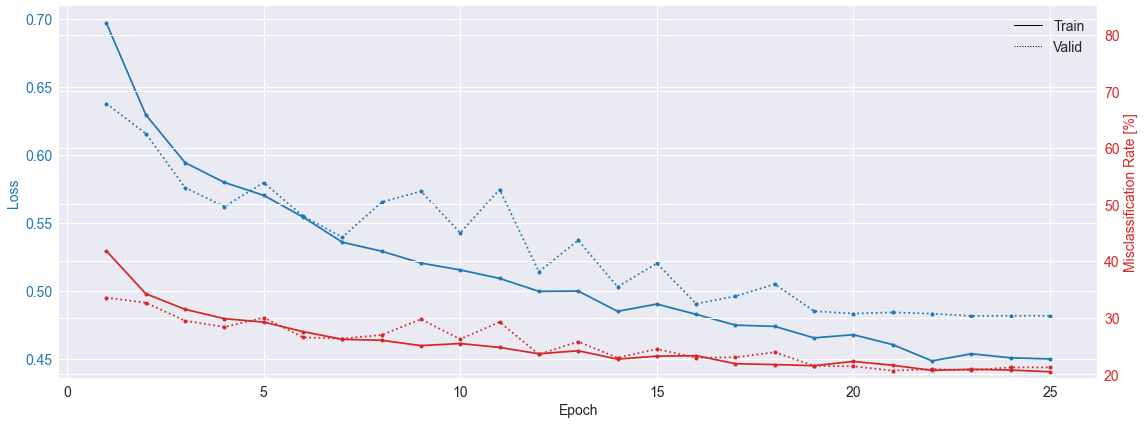

In [72]:
task = "N170"
lr = 0.01
clf, model = Training.init_model(model_name, lr)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_"+str(lr)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_"+str(lr)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_"+str(lr)+"_history.json")


## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_balanced_accuracy", "valid_balanced_accuracy"]
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

### Shallow

In [58]:
## Shallow LR testing
preprocessing = "medium"
model_name = "shallow"
model_folder = "HyperparameterTesting"
n_epochs = 25
n_splits = 1

# run all tasks for different learning rates
results = []
for task in ["N170", "N400", "P3"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.05, 0.01, 0.005]:
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64, additional_save_param="_"+str(lr))
        accuracy = Training.load_exp(model_folder, model_name, task, 
                                     preprocessing, n_splits, 
                                     additional_save_param="_"+str(lr))["valid_balanced_accuracy"][n_epochs-1]
        results.append((task, lr, accuracy))

# save results        
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
df_path = os.getcwd()+"\\HyperparameterTesting\\"
df.to_csv(df_path+"shallow_lr.csv",index=False)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5262        1.9073                     0.5093        1.1244  0.0500  0.4588
      2                     0.5334        1.1850                     0.5265        1.0219  0.0498  0.4508
      3                     0.5422        1.0494                     0.5841        0.7344  0.0491  0.4867
      4                     0.5870        0.7562                     0.6296        0.6456  0.0481  0.4566
      5                     0.6027        0.6938                     0.6774        0.6211  0.0467  0.4850
      6                     0.6282        0.6588                     0.6714        0.6203  0.0448  0.5123
      7                     0.6387        0.6533              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5210        1.0424                     0.5569        0.7331  0.0100  0.4458
      2                     0.5332        0.7908                     0.5831        0.6729  0.0100  0.4489
      3                     0.5594        0.7779                     0.6034        0.7361  0.0098  0.4817
      4                     0.5696        0.7883                     0.6163        0.6492  0.0096  0.4807
      5                     0.6079        0.7074                     0.6401        0.6381  0.0093  0.4508
      6                     0.6326        0.6860                     0.6531        0.6257  0.0090  0.4515
      7                     0.6503        0.6682                     0.7074        0.5642  0.0085  0.4528
      8                     0.6727        0.63

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5204        1.0187                     0.5570        0.6945  0.0050  0.4468
      2                     0.5485        0.7702                     0.5678        0.7068  0.0050  0.4488
      3                     0.5695        0.7190                     0.5919        0.6752  0.0049  0.4494
      4                     0.5927        0.6990                     0.5842        0.6864  0.0048  0.4498
      5                     0.6088        0.6885                     0.6005        0.6636  0.0047  0.4489
      6                     0.6183        0.6805                     0.6657        0.6046  0.0045  0.4498
      7                     0.6476        0.6489                     0.6679        0.6085  0.0043  0.4488
      8                     0.6492        0.65

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5729        2.4341                     0.6164        1.7459  0.0500  0.2663
      2                     0.6106        1.3505                     0.6138        1.2521  0.0498  0.2713
      3                     0.6342        1.2977                     0.6165        1.2559  0.0491  0.2706
      4                     0.6294        1.5371                     0.6143        0.9055  0.0481  0.2693
      5                     0.6391        1.2348                     0.6587        0.7402  0.0467  0.2703
      6                     0.6619        0.7924                     0.6781        0.7042  0.0448  0.2703
      7                     0.6862        0.7049              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5572        0.9904                     0.6490        0.7088  0.0100  0.2663
      2                     0.6453        0.7653                     0.6555        0.6958  0.0100  0.2693
      3                     0.6604        0.7346                     0.6828        0.6234  0.0098  0.2693
      4                     0.6808        0.6988                     0.6791        0.5974  0.0096  0.2693
      5                     0.6513        0.7381                     0.7080        0.5777  0.0093  0.2693
      6                     0.6871        0.6408                     0.7147        0.6311  0.0090  0.2684
      7                     0.7123        0.6230                     0.7124        0.6102  0.0085  0.2683
      8                     0.6962        0.65

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5541        0.9934                     0.6657        0.6274  0.0050  0.2663
      2                     0.6418        0.7288                     0.6775        0.6629  0.0050  0.2713
      3                     0.6670        0.6469                     0.6899        0.5704  0.0049  0.2683
      4                     0.7009        0.6073                     0.6800        0.6303  0.0048  0.2693
      5                     0.6804        0.6229                     0.7305        0.5577  0.0047  0.2703
      6                     0.7261        0.5549                     0.7310        0.5670  0.0045  0.2693
      7                     0.7389        0.5318                     0.6885        0.6099  0.0043  0.2691
      8                     0.7439        0.53

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5686        2.7066                     0.5896        2.3015  0.0500  0.5800
      2                     0.6060        1.3322                     0.6506        0.8946  0.0498  0.5850
      3                     0.6436        0.8204                     0.6508        0.7890  0.0491  0.5875
      4                     0.6471        0.7113                     0.6941        0.5837  0.0481  0.5874
      5                     0.6516        0.6882                     0.7089        0.5857  0.0467  0.5845
      6                     0.6745        0.6234                     0.6035        0.7302  0.0448  0.5845
      7                     0.6674        0.6266              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5735        1.0393                     0.6633        0.5980  0.0100  0.5815
      2                     0.6334        0.7479                     0.5719        0.9891  0.0100  0.5854
      3                     0.6305        0.7758                     0.6631        0.6785  0.0098  0.6622
      4                     0.6701        0.6961                     0.6758        0.7227  0.0096  0.6223
      5                     0.6670        0.7191                     0.6861        0.6207  0.0093  0.6105
      6                     0.6952        0.6186                     0.7337        0.5361  0.0090  0.5984
      7                     0.6923        0.6366                     0.7299        0.5588  0.0085  0.6268
      8                     0.7063        0.62

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5821        0.9172                     0.6833        0.5931  0.0050  0.5885
      2                     0.6227        0.7359                     0.6403        0.6563  0.0050  0.5874
      3                     0.6593        0.6857                     0.7079        0.5788  0.0049  0.5895
      4                     0.6840        0.6147                     0.7112        0.5719  0.0048  0.5872
      5                     0.6942        0.6154                     0.7205        0.5569  0.0047  0.5894
      6                     0.7197        0.5783                     0.7100        0.5560  0.0045  0.5884
      7                     0.6991        0.6050                     0.7344        0.5318  0.0043  0.5848
      8                     0.6966        0.62

In [60]:
df = pd.read_csv(df_path+"shallow_lr.csv")
df.groupby(["LR"]).mean()

,valid_balanced_accuracy
LR,
0.005,0.746131
0.010,0.750709
0.050,0.741091


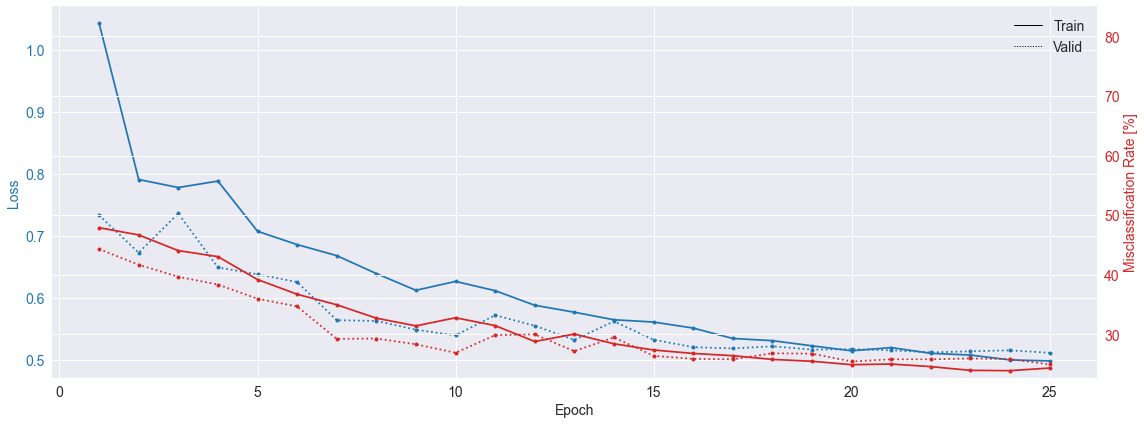

In [74]:
task = "N170"
lr = 0.01
clf, model = Training.init_model(model_name, lr)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_"+str(lr)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_"+str(lr)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_"+str(lr)+"_history.json")


## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_balanced_accuracy", "valid_balanced_accuracy"]
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

### Deep

In [61]:
## Deep LR testing
preprocessing = "medium"
model_name = "deep"
model_folder = "HyperparameterTesting"
n_epochs = 25
n_splits = 1

# run all tasks for different learning rates
results = []
for task in ["N170", "N400", "P3"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.05, 0.01, 0.005]:
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64, additional_save_param="_"+str(lr))
        accuracy = Training.load_exp(model_folder, model_name, task, 
                                     preprocessing, n_splits, 
                                     additional_save_param="_"+str(lr))["valid_balanced_accuracy"][n_epochs-1]
        results.append((task, lr, accuracy))

# save results        
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
df_path = os.getcwd()+"\\HyperparameterTesting\\"
df.to_csv(df_path+"deep_lr.csv",index=False)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5163        2.4686                     0.5395        0.7287  0.0500  0.4857
      2                     0.5514        0.7258                     0.5707        0.6908  0.0498  0.4668
      3                     0.5960        0.6850                     0.6214        0.6467  0.0491  0.4629
      4                     0.6285        0.6473                     0.6668        0.6162  0.0481  0.4607
      5                     0.6588        0.6186                     0.6831        0.6044  0.0467  0.4618
      6                     0.6814        0.5989                     0.7078        0.5724  0.0448  0.4598
      7                     0.6969        0.5892              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5434        1.2061                     0.6360        0.6536  0.0100  0.4638
      2                     0.6110        0.7816                     0.6849        0.6537  0.0100  0.4576
      3                     0.6632        0.6572                     0.7089        0.5877  0.0098  0.4628
      4                     0.6848        0.6168                     0.6363        0.6630  0.0096  0.4579
      5                     0.6883        0.6133                     0.7282        0.5441  0.0093  0.4588
      6                     0.7180        0.5772                     0.7564        0.5269  0.0090  0.4578
      7                     0.7279        0.5477                     0.7357        0.5317  0.0085  0.4601
      8                     0.7398        0.52

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5786        1.0763                     0.6023        0.7165  0.0050  0.4578
      2                     0.6283        0.7218                     0.7051        0.5892  0.0050  0.4598
      3                     0.6727        0.6293                     0.6899        0.5782  0.0049  0.4578
      4                     0.6838        0.6402                     0.7062        0.5774  0.0048  0.4588
      5                     0.7092        0.5825                     0.7341        0.5467  0.0047  0.4608
      6                     0.7372        0.5329                     0.7488        0.5103  0.0045  0.4578
      7                     0.7530        0.5217                     0.7489        0.4882  0.0043  0.4573
      8                     0.7486        0.52

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6048        2.5245                     0.4350        3.5348  0.0500  0.2743
      2                     0.6458        1.2581                     0.5493        0.7168  0.0498  0.2783
      3                     0.6745        0.6144                     0.6633        0.6138  0.0491  0.2773
      4                     0.6924        0.5852                     0.6879        0.5909  0.0481  0.2760
      5                     0.7111        0.5872                     0.7045        0.5717  0.0467  0.2763
      6                     0.7263        0.5399                     0.7011        0.5523  0.0448  0.2760
      7                     0.7103        0.5795              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6235        1.1815                     0.5542        1.3019  0.0100  0.2743
      2                     0.6565        0.8986                     0.5681        0.9386  0.0100  0.2761
      3                     0.7142        0.5894                     0.7380        0.5419  0.0098  0.2753
      4                     0.6919        0.6410                     0.6355        0.7125  0.0096  0.2758
      5                     0.6778        0.7110                     0.5132        0.8762  0.0093  0.2743
      6                     0.7286        0.5675                     0.6655        0.7677  0.0090  0.2783
      7                     0.6723        0.7814                     0.7151        0.5509  0.0085  0.2773
      8                     0.7162        0.54

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6199        1.0931                     0.6112        0.7457  0.0050  0.2753
      2                     0.6875        0.6951                     0.6351        0.6549  0.0050  0.2770
      3                     0.7216        0.5805                     0.7209        0.5918  0.0049  0.2773
      4                     0.7150        0.6060                     0.6728        0.7519  0.0048  0.2778
      5                     0.6832        0.6716                     0.7062        0.5923  0.0047  0.2753
      6                     0.7298        0.5482                     0.7090        0.5561  0.0045  0.2763
      7                     0.7028        0.6196                     0.7122        0.5828  0.0043  0.2768
      8                     0.7293        0.54

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5439        2.0716                     0.5449        0.7072  0.0500  0.5972
      2                     0.6149        0.6595                     0.6785        0.6196  0.0498  0.5967
      3                     0.6505        0.6271                     0.6881        0.6163  0.0491  0.5974
      4                     0.6652        0.6228                     0.6858        0.6061  0.0481  0.5947
      5                     0.6767        0.6085                     0.6864        0.5891  0.0467  0.5984
      6                     0.6604        0.6401                     0.6943        0.5745  0.0448  0.5976
      7                     0.6836        0.6101              

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.5821        1.2667                     0.5666        1.0100  0.0100  0.5954
      2                     0.6175        0.7424                     0.6189        0.6491  0.0100  0.5960
      3                     0.6617        0.6424                     0.7172        0.5723  0.0098  0.5974
      4                     0.6763        0.6410                     0.6922        0.5798  0.0096  0.5974
      5                     0.6916        0.5956                     0.7064        0.5587  0.0093  0.5950
      6                     0.6975        0.5838                     0.7014        0.5609  0.0090  0.5945
      7                     0.7151        0.5666                     0.7212        0.5489  0.0085  0.5971
      8                     0.7244        0.55

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


  epoch    train_balanced_accuracy    train_loss    valid_balanced_accuracy    valid_loss      lr     dur
-------  -------------------------  ------------  -------------------------  ------------  ------  ------
      1                     0.6057        1.0500                     0.5868        1.0664  0.0050  0.5974
      2                     0.6354        0.7435                     0.6097        0.6702  0.0050  0.5980
      3                     0.6594        0.6821                     0.7090        0.5899  0.0049  0.5959
      4                     0.6736        0.6704                     0.7236        0.5517  0.0048  0.5968
      5                     0.6892        0.6099                     0.6994        0.5780  0.0047  0.5965
      6                     0.6838        0.6267                     0.6869        0.6313  0.0045  0.5961
      7                     0.7057        0.5773                     0.6924        0.5967  0.0043  0.5984
      8                     0.7291        0.54

In [62]:
df = pd.read_csv(df_path+"deep_lr.csv")
df.groupby(["LR"]).mean()

,valid_balanced_accuracy
LR,
0.005,0.774592
0.010,0.779527
0.050,0.765937


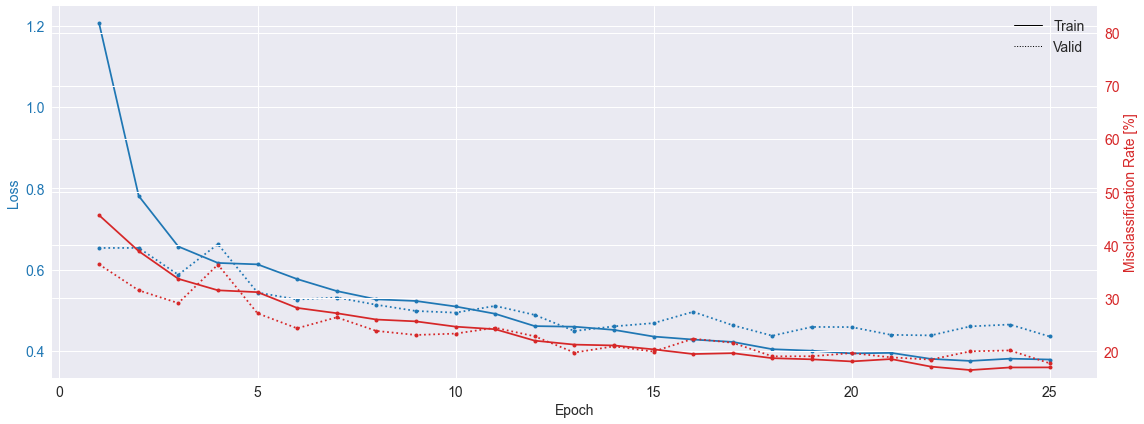

In [76]:
task = "N170"
lr = 0.01
clf, model = Training.init_model(model_name, lr)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_"+str(lr)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_"+str(lr)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_"+str(lr)+"_history.json")


## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_balanced_accuracy", "valid_balanced_accuracy"]
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()